In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import datetime
import os
import time
from datetime import datetime
import pandas as pd
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score, average_precision_score, precision_recall_curve
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler
from sklearn import tree
import sklearn.metrics as metric
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from tabulate import tabulate
from sklearn.model_selection import KFold
from sklearn import metrics
from warnings import simplefilter
from sklearn.metrics import roc_curve, roc_auc_score


/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv


In [2]:
df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
fraud = df[df["isFraud"] == 1]
nonfraud = df[df["isFraud"] == 0]

In [4]:
print("Average of frauds: \n",fraud.TransactionAmt.mean())
print("Average of nonfrauds: \n", nonfraud.TransactionAmt.mean())
print("Maximum frauds: \n",fraud.TransactionAmt.max())
print("Minimum frauds: \n",fraud.TransactionAmt.min())
print("Maximum nonfrauds: \n", nonfraud.TransactionAmt.max())
print("Minimum nonfrauds: \n", nonfraud.TransactionAmt.min())

Average of frauds: 
 149.2447785897534
Average of nonfrauds: 
 134.51166457896034
Maximum frauds: 
 5191.0
Minimum frauds: 
 0.292
Maximum nonfrauds: 
 31937.391
Minimum nonfrauds: 
 0.251


In [5]:
catFeatures=['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',	'M2',	'M3',	'M4',	'M5',	'M6',	'M7',	'M8',	'M9', 'C1','V12','V13','V14','V15','V16']

numFeatures=list(df)
for x in catFeatures:
  numFeatures.remove(x)

numFeatures.remove('isFraud')
df['isFraud'] = df['isFraud'].astype(int)

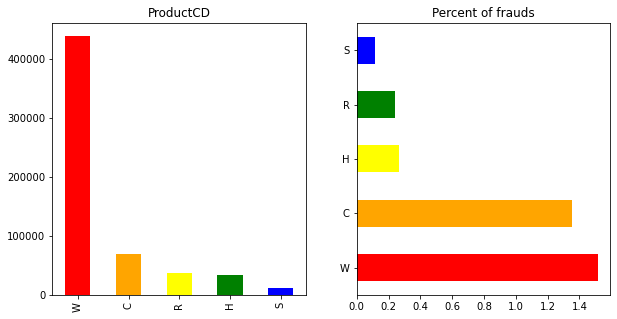

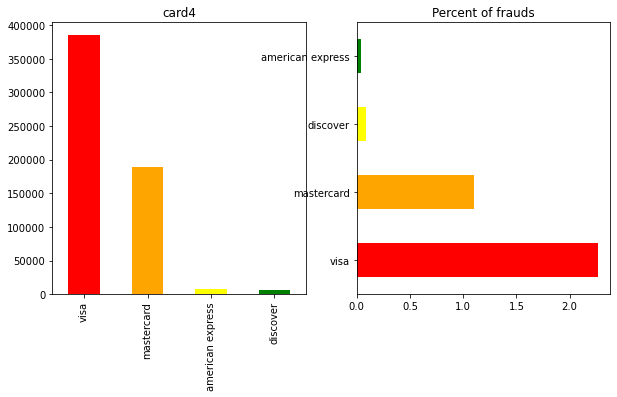

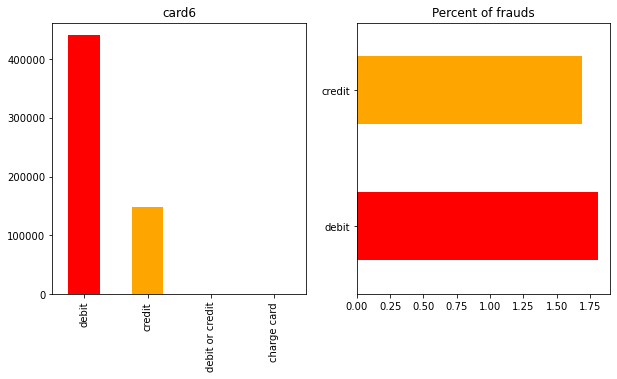

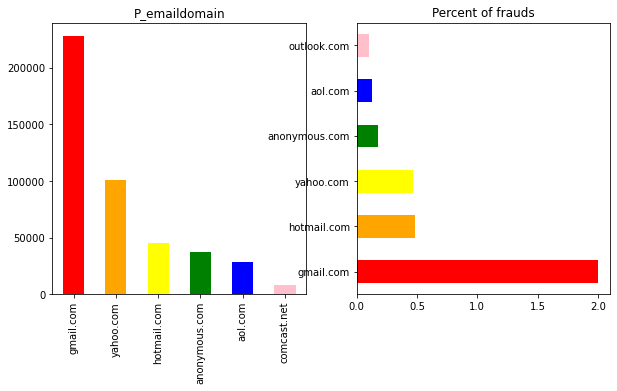

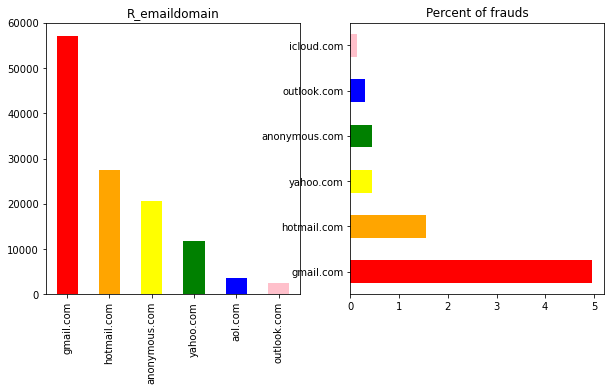

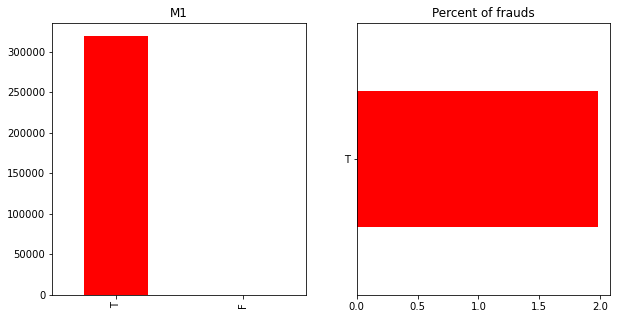

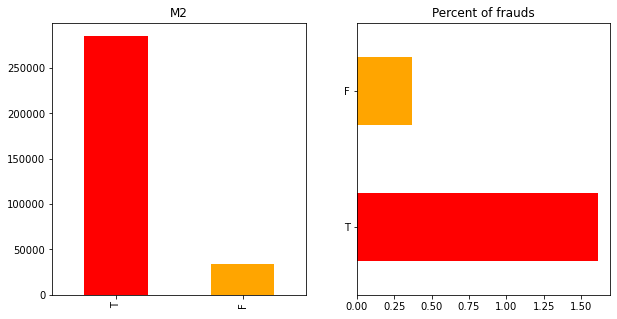

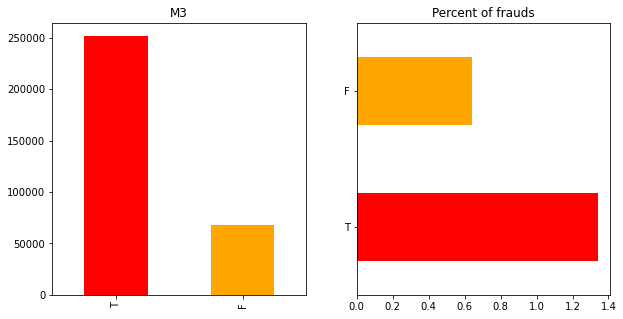

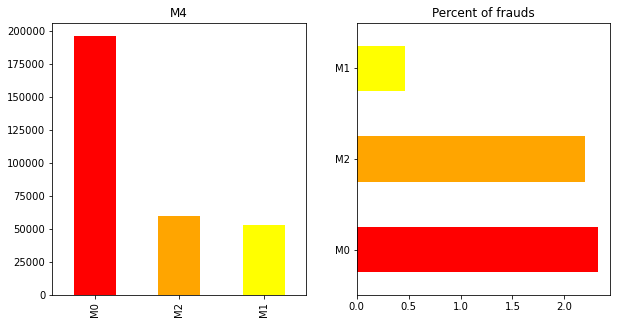

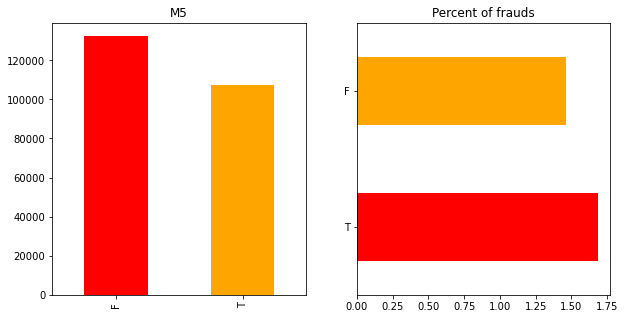

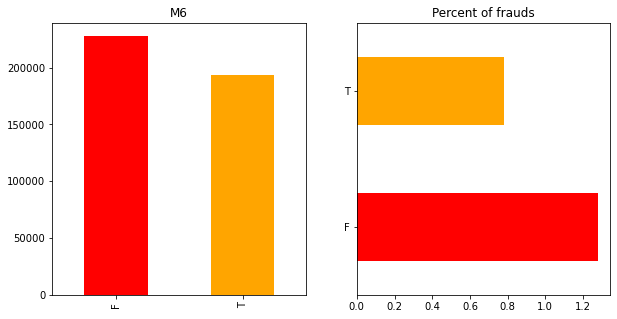

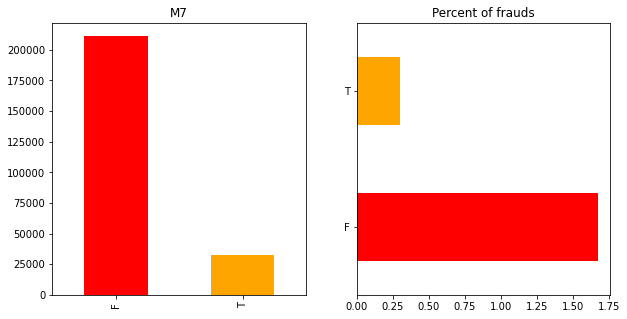

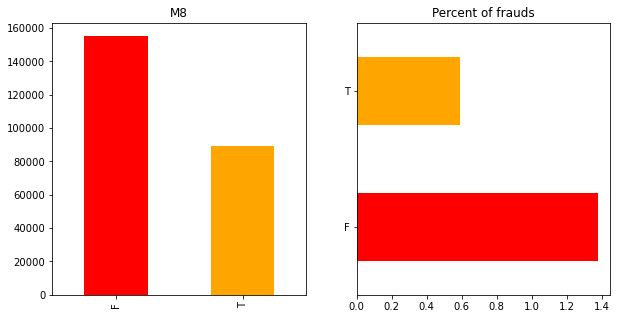

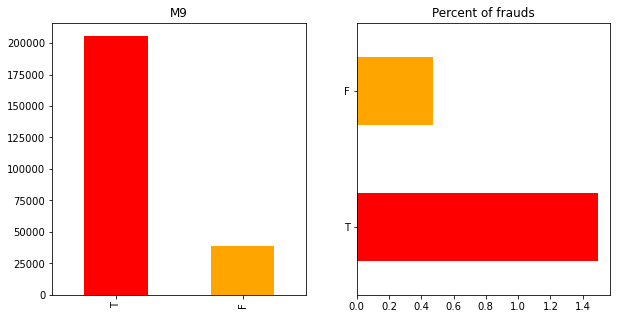

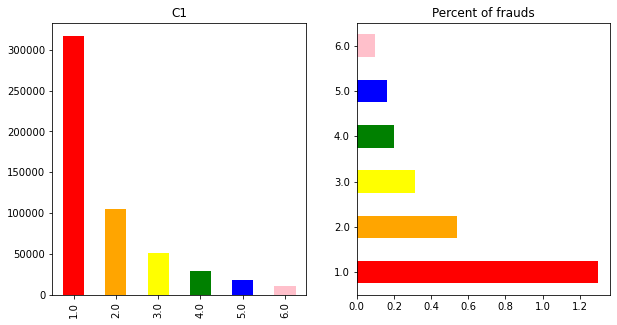

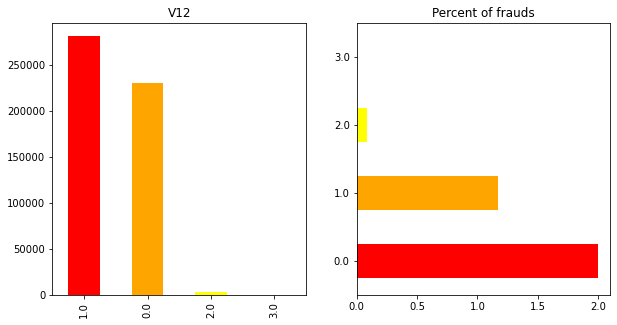

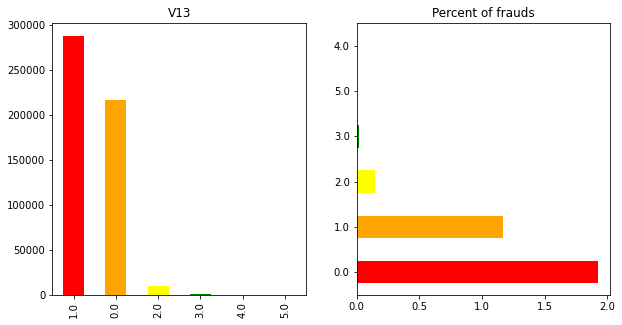

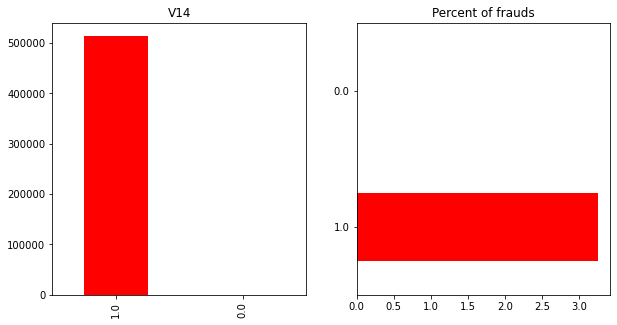

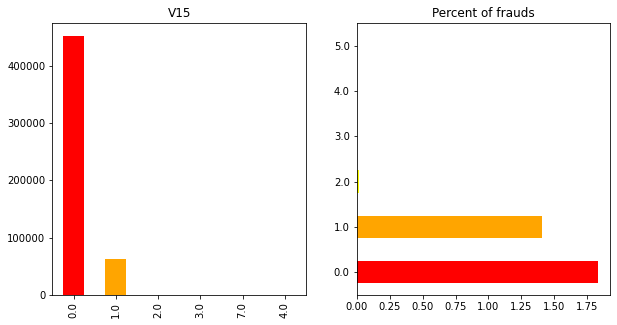

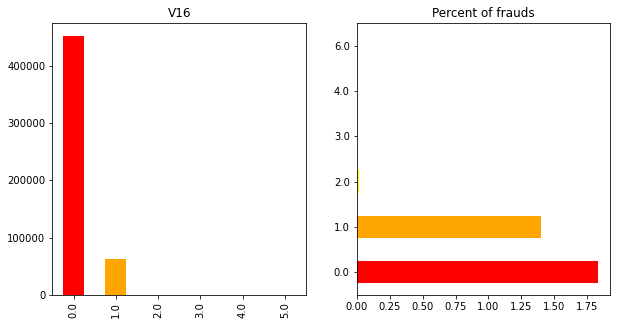

In [6]:
for catFeatures_val in catFeatures:
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    colors=['red', 'orange', 'yellow', 'green', 'blue', 'pink']
    (df[catFeatures_val].value_counts().head(6)).plot(kind='bar', title=catFeatures_val,  ax=ax[0], color=colors)
    ((fraud[catFeatures_val].value_counts()*100/df[catFeatures_val].count()).head(6)).plot(kind='barh', title='Percent of frauds', ax=ax[1],color=colors)

plt.show()

In [7]:
missings = df.isnull().sum()
all_data = np.product(df.shape)
all_missings = missings.sum()
print ("Percent of missings ",(all_missings/all_data) * 100)

Percent of missings  41.073431200111266


In [8]:
('Percent of frauds:', (len(fraud)/len(df))*100)

('Percent of frauds:', 3.4990009144173126)

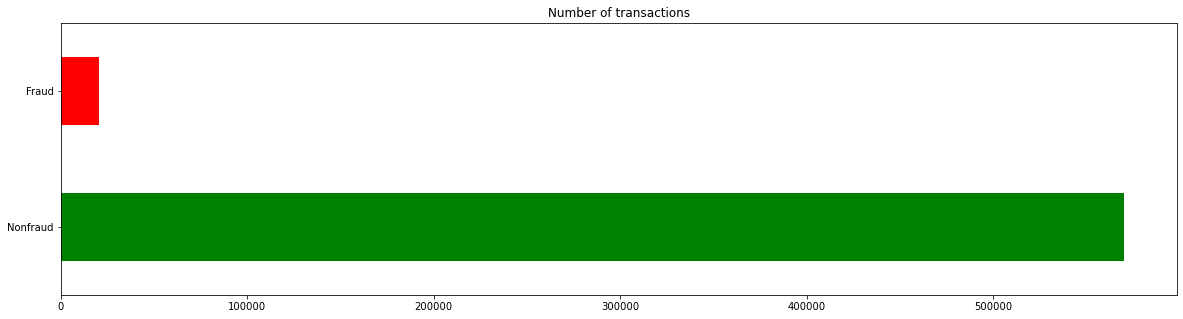

In [9]:
legend = df['isFraud'].replace({0: "Nonfraud", 1: "Fraud"})
colors=['green', 'red']
(legend.value_counts().head(6)).plot(kind='barh', title=('Number of transactions'), color=colors,figsize=(20, 5), )
del legend

<h1>Variable transformation and prepare data to training</h1>

In [10]:
hours = df['TransactionDT'] / (3600) #Preparation of a variable showing hours based on variable TransactionDT
hours_ = np.floor(hours) % 24
df['hours'] = hours_


In [11]:
missings = [df[col].isnull().sum() / df.shape[0] for col in df.columns] #Delete columns with 50% of missings values
cols_to_out = [df.columns[i] for i in range(df.shape[1]) if missings[i] > 0.5]
df = df.drop(cols_to_out, axis=1)

In [12]:
identical = [c for c in df.columns if df[c].value_counts(normalize=True).values[0] > 0.9] #Delete columns with 90% the same values
throw_away = identical
throw_away.remove('isFraud')
df = df.drop(throw_away, axis=1)

In [13]:
df = df.drop(columns=['TransactionID', 'TransactionDT'])


In [14]:
pd.set_option('display.max_columns', None)
df.head(10)



,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,P_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D10,D11,D15,M2,M3,M4,M6,V4,V5,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V39,V40,V42,V43,V48,V49,V50,V51,V52,V53,V54,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V79,V80,V81,V82,V83,V84,V85,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,hours
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,13.0,13.0,0.0,T,T,M2,T,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,gmail.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,M0,T,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,outlook.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,315.0,315.0,T,T,M0,F,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,yahoo.com,2.0,5.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,84.0,NaN,111.0,NaN,NaN,M0,F,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,28.0,10.0,4.0,50.0,1758.0,925.0,354.0,135.0,1.0,28.0,0.0,0.0,10.0,4.0,0.0,0.0,1.0,1.0,38.0,0.0,0.0,0.0,50.0,1758.0,925.0,354.0,135.0,0.0,0.0,0.0,1404.0,0.0
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,gmail.com,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,gmail.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,T,T,M1,T,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,yahoo.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,T,T,M0,F,1

In [15]:
print('Before transformations: ') #Reduction number of categories in P_emaildomain
print('Number of lvls P_emaildomain : ',len(df['P_emaildomain'].value_counts()))

Before transformations: 
Number of lvls P_emaildomain :  59


In [16]:
df['P_emaildomain'].replace({'aim.com' :  'other' ,
 'anonymous.com' :  'anonymous' ,
 'aol.com' :  'aol' ,
 'att.net' :  'other' ,
 'bellsouth.net' :  'other' ,
 'cableone.net' :  'other' ,
 'centurylink.net' :  'other' ,
 'cfl.rr.com' :  'other' ,
 'charter.net' :  'other' ,
 'comcast.net' :  'other' ,
 'cox.net' :  'other' ,
 'earthlink.net' :  'other' ,
 'embarqmail.com' :  'other' ,
 'frontier.com' :  'frontier' ,
 'frontiernet.net' :  'frontier' ,
 'gmail' :  'gmail' ,
 'gmail.com' :  'gmail' ,
 'gmx.de' :  'other' ,
 'hotmail.co.uk' :  'hotmail' ,
 'hotmail.com' :  'hotmail' ,
 'hotmail.de' :  'hotmail' ,
 'hotmail.es' :  'hotmail' ,
 'hotmail.fr' :  'hotmail' ,
 'icloud.com' :  'other' ,
 'juno.com' :  'other' ,
 'live.com' :  'live' ,
 'live.com.mx' :  'live' ,
 'live.fr' :  'live' ,
 'mac.com' :  'other' ,
 'mail.com' :  'other' ,
 'me.com' :  'other' ,
 'msn.com' :  'msn' ,
 'netzero.com' :  'netzero' ,
 'netzero.net' :  'netzero' ,
 'optonline.net' :  'other' ,
 'outlook.com' :  'outlook' ,
 'outlook.es' :  'outlook' ,
 'prodigy.net.mx' :  'other' ,
 'protonmail.com' :  'other' ,
 'ptd.net' :  'other' ,
 'q.com' :  'other' ,
 'roadrunner.com' :  'other' ,
 'rocketmail.com' :  'other' ,
 'sbcglobal.net' :  'other' ,
 'sc.rr.com' :  'other' ,
 'servicios-ta.com' :  'other' ,
 'suddenlink.net' :  'other' ,
 'twc.com' :  'other' ,
 'verizon.net' :  'other' ,
 'web.de' :  'other' ,
 'windstream.net' :  'other' ,
 'yahoo.co.jp' :  'yahoo' ,
 'yahoo.co.uk' :  'yahoo' ,
 'yahoo.com' :  'yahoo' ,
 'yahoo.com.mx' :  'yahoo' ,
 'yahoo.de' :  'yahoo' ,
 'yahoo.es' :  'yahoo' ,
 'yahoo.fr' :  'yahoo' ,
 'ymail.com' :  'other' ,},inplace=True)
print('After transformations: ')
print('Number of lvls P_emaildomain : ',len(df['P_emaildomain'].value_counts()))


After transformations: 
Number of lvls P_emaildomain :  11


In [17]:
catFeatures=['ProductCD', 'card4', 'card6', 'P_emaildomain',	'M2',	'M3',	'M4','M6', 'C1','V12','V13','V15','V16']

numFeatures=list(df)
try:
    
    for x in catFeatures:
      numFeatures.remove(x)
except:
    pass

numFeatures.remove('isFraud')

In [26]:
df.fillna(-999, inplace=True)
for x in catFeatures:
    df[x] = df[x].astype(str)

In [27]:
mapy={}
for feature in catFeatures:
    le = preprocessing.LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    mapy[feature] = le

In [20]:
features = list(df)
features.remove('isFraud')
target='isFraud'

In [21]:
smote = SMOTE(n_jobs=-1, random_state=2020)
adas = ADASYN(random_state=2020)
ros = RandomOverSampler( random_state=2020)
tom = TomekLinks()
rus = RandomUnderSampler(random_state=2020)
nm=NearMiss()

<h1>Prepare wrapper and AUPRplot</h1>

In [37]:
def wrapper(nFolds = 5, randomState=2020, debug=False, features=features, df=df, sampling=False, sampler=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    TestResults=[]
    TrainResults=[]
    predictions=[]
    indices = []
    for train, test in kf.split(df.index.values):
        clf = DecisionTreeClassifier(*args, **kwargs, random_state=randomState)
        if debug:
            print(clf)
        
        X_train, y_train = df.iloc[train][features], df.iloc[train][target] 
        X_test, y_test = df.iloc[test][features], df.iloc[test][target]

        if sampling:
          X_train, y_train = sampler.fit_sample(X_train, y_train)

        clf.fit(X_train, y_train)
        predsTrain = clf.predict_proba(X_train)[:,1]
        preds = clf.predict_proba(X_test)[:,1]
                              
        predictions.append(preds.tolist().copy())
        
        indices.append(df.iloc[test].index.tolist().copy())
        
        TrainScore = average_precision_score((y_train==1).astype(int), predsTrain)
        TestScore = average_precision_score((y_test==1).astype(int), preds)
        TrainResults.append(TrainScore)
        TestResults.append(TestScore)


    return  predictions, indices, TestResults, TrainResults


In [40]:
def plotAUPR(results):

	fig, ax = plt.subplots(figsize=(10,9))

	for true, pred, label in results:
		precision, recall, thresholds = precision_recall_curve(true, pred)
		average_precision = average_precision_score(true, pred)
		average_precision = round(average_precision, 4)
		lw=2
		ax.plot(recall, precision, lw=lw, label=f'{label}: {average_precision}')
  

	ax.set_xlim([0, 1])
	ax.set_ylim([0.0, 1.01])
	ax.set_xlabel('Recall')
	ax.set_ylabel('Precision')
	ax.set_title(f'Precision Recall Curve ')
	ax.legend(loc="lower right")
	plt.show()

<h1>Training</h1>

Sampling methods was training on the best hiperparameters for main Decision Tree model.
AUPR is better to predicting fraud, because better shows the difference of models for unbalanced data

In [39]:
rec2plot=[]

std=[]
valid_train=[]
valid_test=[]

predictions, indices, TestResults, TrainResults = wrapper(df=df,max_depth=21,
                                                                    min_samples_split=60, min_samples_leaf=50, max_features=37)
print( "std: ", np.std(predictions), 'train AUPR:', np.mean(TrainResults), 'test AUPR: ',np.mean(TestResults) )
std.append(np.std(predictions))
valid_train.append(np.mean(TrainResults))
valid_test.append(np.mean(TestResults))


true = (df[target]==1).astype(int).sort_index()
pred = pd.Series(sum(predictions, []), index=sum(indices, [])).sort_index()
rec2plot.append((true, pred, "DT"))



print('-----------------DT END')
n=''

for k in [rus,nm,tom,ros,smote,adas]:

  if k==rus:
    n='RandomUnderSampler'
  elif k==ros :
    n='RandomOverSampler'
  elif k==smote:
    n='SMOTE'
  elif k==nm:
    n='NearMiss'
  elif k==tom:
    n='TomekLinks'
  else:
    n='ADASYN'

  predictions, indices, TestResults, TrainResults = wrapper(df=df, max_depth=21,
                                                                    min_samples_split=60, min_samples_leaf=50, max_features=37, sampling=True, sampler=k)
  print( "std: ", np.std(predictions), 'train AUPR:', np.mean(TrainResults), 'test AUPR: ',np.mean(TestResults))
  valid_train.append(np.mean(TrainResults))
  valid_test.append(np.mean(TestResults))
  std.append(np.std(predictions))
  
  name = 'modelDT+'+  n


  true = (df[target]==1).astype(int).sort_index()
  pred = pd.Series(sum(predictions, []), index=sum(indices, [])).sort_index()
  rec2plot.append((true, pred, name))


  print('------------------------')

plotAUPR(rec2plot)


std:  0.11139764140704149 train AUPR: 0.5739081513227904 test AUPR:  0.5008159100788985
-----------------DT END
std:  0.25738518883964023 train AUPR: 0.9074037715382826 test AUPR:  0.36339728687683587
------------------------
std:  0.27941289635130234 train AUPR: 0.9883836851040335 test AUPR:  0.03606120416473667
------------------------
std:  0.11258095360625095 train AUPR: 0.5747107912622278 test AUPR:  0.49787092478655026
------------------------
std:  0.26091060015365397 train AUPR: 0.9690587610535978 test AUPR:  0.4864362660711083
------------------------
std:  0.19776979668417913 train AUPR: 0.9908833990998385 test AUPR:  0.423528279999186
------------------------
std:  0.2047744614530272 train AUPR: 0.9900660803913883 test AUPR:  0.4032362634659738
------------------------


TypeError: plotAPC() got an unexpected keyword argument 'k'

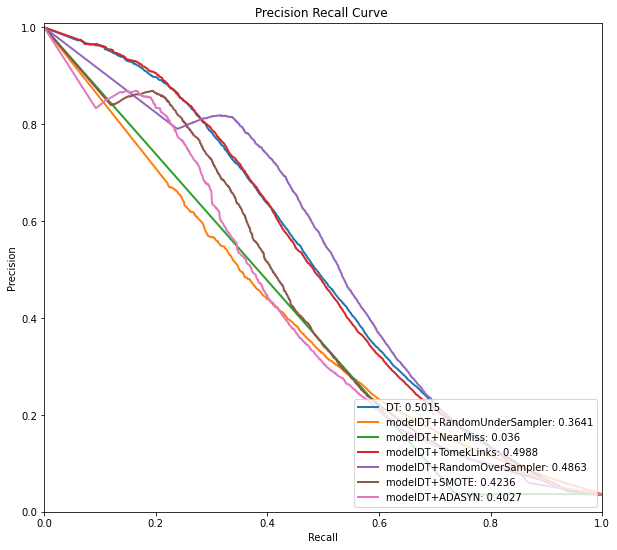

In [42]:
plotAUPR(rec2plot)